# Milestone 3 - Second Model II

In [1]:
# imports 
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import torch
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from second_scripts import *
from scripts import *

### I. Data Prepration

In [2]:
# Read the data
# data_path = './data'
data_path = './DLCV_SS25_Dataset'  
images, labels = data_reader2(data_path)


In [3]:
num_classes = len(os.listdir(data_path))
num_classes

5

In [4]:
len(images)

2351

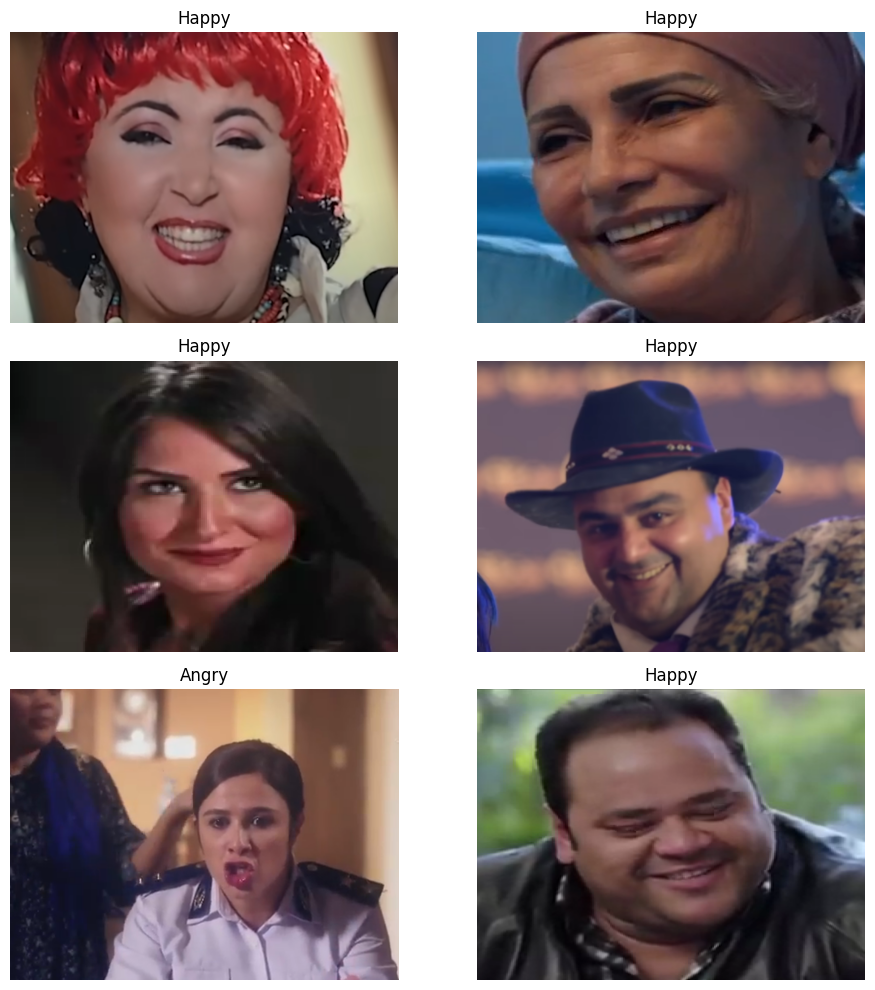

In [5]:
# View 4 random images and their titles
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(images))
    ax.imshow(images[idx])
    ax.set_title(labels[idx])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Preprocess the images 
train_tuple, val_tuple, test_tuple, label_to_index = data_preperator2((images, labels))
index_to_label = {v: k for k, v in label_to_index.items()}

train_data, train_labels = train_tuple
val_data, val_labels = val_tuple
test_data, test_labels = test_tuple

train_data.shape, train_labels.shape, val_data.shape, val_labels.shape, test_data.shape, test_labels.shape

((1645, 512, 512, 3),
 (1645,),
 (470, 512, 512, 3),
 (470,),
 (236, 512, 512, 3),
 (236,))

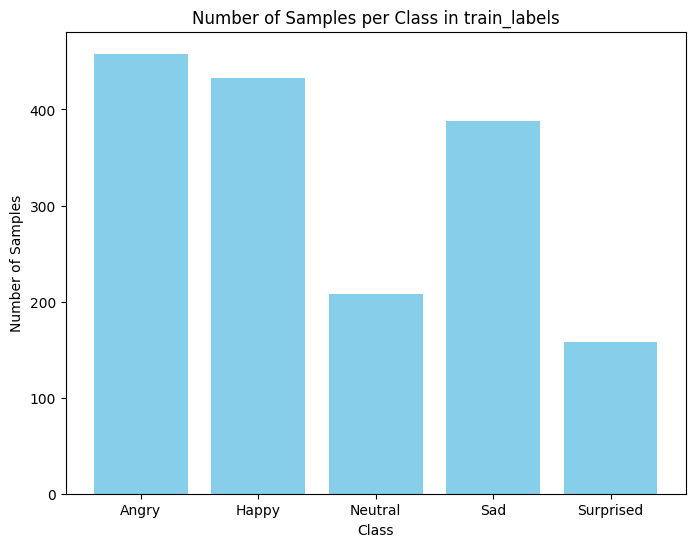

In [7]:
draw_barchart_labels(train_labels, label_to_index)

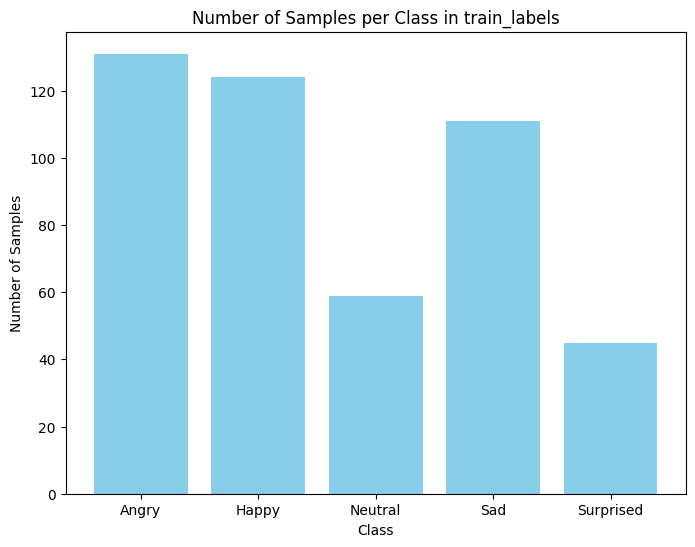

In [8]:
draw_barchart_labels(val_labels, label_to_index)

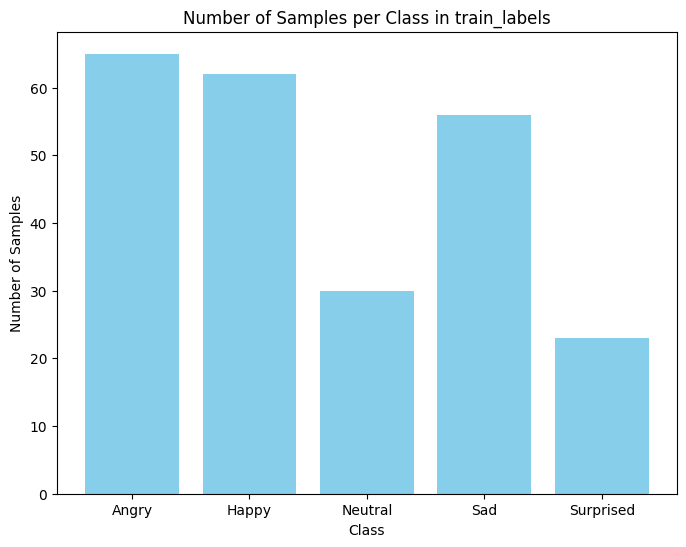

In [9]:
draw_barchart_labels(test_labels, label_to_index)

In [10]:
def kfold_indices(
    n_samples: int, 
    k: int, 
    random_state: int = 42
) -> Iterator[Tuple[List[int], List[int]]]:
    """
    Yield train/val index splits for standard K-fold.
    """
    rng = np.random.RandomState(random_state)
    indices = np.arange(n_samples)

    base_size = n_samples // k
    sizes = [base_size + (1 if i < (n_samples % k) else 0) for i in range(k)]
    print(f"Fold sizes: {sizes}")

    folds = []
    start = 0
    for size in sizes:
        folds.append(indices[start:start+size])
        start += size

    for i in range(k):
        val_idx = folds[k-i-1].tolist()
        train_idx = np.hstack([folds[j] for j in range(k) if j != k-i-1]).tolist()
        yield train_idx, val_idx

In [11]:
for train_idx, val_idx in kfold_indices(len(train_data), 5, random_state=42):
    print(f"Train indices: {train_idx}")
    print(f"Validation indices: {val_idx}")
    print('-'*50)

Fold sizes: [329, 329, 329, 329, 329]
Train indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

### II. Second Model

In [12]:
train_loader = convert_to_dataloader(data=(train_data, train_labels), batch_size=16, shuffle=True)
val_loader = convert_to_dataloader(data=(val_data, val_labels), batch_size=16, shuffle=False)
test_loader = convert_to_dataloader(data=(test_data, test_labels), batch_size=16, shuffle=False)

In [13]:
second_model = SecondModel3()
summary(second_model, input_size=(3, 512, 512), batch_size=1, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 32, 510, 510]             896
            Conv2d-2          [1, 32, 508, 508]           9,248
            Conv2d-3          [1, 32, 506, 506]           9,248
              ReLU-4          [1, 32, 506, 506]               0
         MaxPool2d-5          [1, 32, 253, 253]               0
       BatchNorm2d-6          [1, 32, 253, 253]              64
         CNNBlock2-7          [1, 32, 253, 253]               0
            Conv2d-8          [1, 64, 251, 251]          18,496
            Conv2d-9          [1, 64, 249, 249]          36,928
           Conv2d-10          [1, 64, 247, 247]          36,928
             ReLU-11          [1, 64, 247, 247]               0
        MaxPool2d-12          [1, 64, 123, 123]               0
      BatchNorm2d-13          [1, 64, 123, 123]             128
        CNNBlock2-14          [1, 64, 1

In [14]:
from torch.utils.data import ConcatDataset
cross_validate_train_ds = ConcatDataset([train_loader.dataset, val_loader.dataset])

fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies, best_model = cross_validate(
                                                                                                train_ds=cross_validate_train_ds,
                                                                                                model_fn=SecondModel3,
                                                                                                k=5,
                                                                                                num_epochs=10,
                                                                                                batch_size=16,
                                                                                                num_workers=4,
                                                                                                lr= 1e-3,
                                                                                                random_state= 42)

Fold sizes: [423, 423, 423, 423, 423]

--- Fold 1/5 ---


Epoch [1/10]


train_Loss: 1.5640  train_Acc: 0.3061  train_Prec: 0.2143  train_Rec: 0.2301  train_F1: 0.1519  train_ROC-AUC: 0.5880


val_Loss: 1.5910  val_Acc: 0.2790  val_Prec: 0.1914  val_Rec: 0.2183  val_F1: 0.1467  val_ROC-AUC: 0.5562
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.4920  train_Acc: 0.3387  train_Prec: 0.2665  train_Rec: 0.2533  train_F1: 0.1940  train_ROC-AUC: 0.6157


val_Loss: 1.5270  val_Acc: 0.3050  val_Prec: 0.1880  val_Rec: 0.2335  val_F1: 0.1753  val_ROC-AUC: 0.5815
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4792  train_Acc: 0.3339  train_Prec: 0.2197  train_Rec: 0.2494  train_F1: 0.1795  train_ROC-AUC: 0.6543


val_Loss: 1.4983  val_Acc: 0.3262  val_Prec: 0.2002  val_Rec: 0.2503  val_F1: 0.1779  val_ROC-AUC: 0.6275
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4229  train_Acc: 0.3995  train_Prec: 0.2353  train_Rec: 0.3027  train_F1: 0.2599  train_ROC-AUC: 0.6798


val_Loss: 1.4589  val_Acc: 0.3381  val_Prec: 0.1947  val_Rec: 0.2596  val_F1: 0.2174  val_ROC-AUC: 0.6510
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4298  train_Acc: 0.3901  train_Prec: 0.2379  train_Rec: 0.2931  train_F1: 0.2427  train_ROC-AUC: 0.6719


val_Loss: 1.4826  val_Acc: 0.3357  val_Prec: 0.1872  val_Rec: 0.2557  val_F1: 0.1980  val_ROC-AUC: 0.6443
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.3924  train_Acc: 0.4220  train_Prec: 0.2769  train_Rec: 0.3228  train_F1: 0.2874  train_ROC-AUC: 0.7100


val_Loss: 1.4394  val_Acc: 0.3617  val_Prec: 0.2382  val_Rec: 0.2798  val_F1: 0.2472  val_ROC-AUC: 0.6659
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4731  train_Acc: 0.3712  train_Prec: 0.3303  train_Rec: 0.2808  train_F1: 0.2246  train_ROC-AUC: 0.6889


val_Loss: 1.5171  val_Acc: 0.3333  val_Prec: 0.3879  val_Rec: 0.2599  val_F1: 0.2018  val_ROC-AUC: 0.6561
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.3478  train_Acc: 0.4480  train_Prec: 0.3652  train_Rec: 0.3407  train_F1: 0.2958  train_ROC-AUC: 0.7222


val_Loss: 1.4170  val_Acc: 0.3712  val_Prec: 0.2191  val_Rec: 0.2860  val_F1: 0.2402  val_ROC-AUC: 0.6864
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3186  train_Acc: 0.4645  train_Prec: 0.3633  train_Rec: 0.3598  train_F1: 0.3296  train_ROC-AUC: 0.7341


val_Loss: 1.3899  val_Acc: 0.4043  val_Prec: 0.2466  val_Rec: 0.3114  val_F1: 0.2733  val_ROC-AUC: 0.6904
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3047  train_Acc: 0.4734  train_Prec: 0.4061  train_Rec: 0.3647  train_F1: 0.3310  train_ROC-AUC: 0.7399


val_Loss: 1.3856  val_Acc: 0.4019  val_Prec: 0.2478  val_Rec: 0.3116  val_F1: 0.2747  val_ROC-AUC: 0.6962
--------------------------------------------------
Fold 1 val accuracy: 0.4019

--- Fold 2/5 ---


Epoch [1/10]


train_Loss: 1.6286  train_Acc: 0.2760  train_Prec: 0.1378  train_Rec: 0.2002  train_F1: 0.0917  train_ROC-AUC: 0.5156


val_Loss: 1.6248  val_Acc: 0.2837  val_Prec: 0.1371  val_Rec: 0.1970  val_F1: 0.0951  val_ROC-AUC: 0.4890
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.4844  train_Acc: 0.3735  train_Prec: 0.2272  train_Rec: 0.2866  train_F1: 0.2497  train_ROC-AUC: 0.6198


val_Loss: 1.4808  val_Acc: 0.3735  val_Prec: 0.2331  val_Rec: 0.2875  val_F1: 0.2547  val_ROC-AUC: 0.6144
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4729  train_Acc: 0.3635  train_Prec: 0.2302  train_Rec: 0.2753  train_F1: 0.2259  train_ROC-AUC: 0.6445


val_Loss: 1.4929  val_Acc: 0.3641  val_Prec: 0.2432  val_Rec: 0.2741  val_F1: 0.2223  val_ROC-AUC: 0.6220
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4746  train_Acc: 0.3481  train_Prec: 0.2619  train_Rec: 0.2615  train_F1: 0.2016  train_ROC-AUC: 0.6381


val_Loss: 1.4891  val_Acc: 0.3475  val_Prec: 0.2996  val_Rec: 0.2598  val_F1: 0.1965  val_ROC-AUC: 0.6266
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4728  train_Acc: 0.3664  train_Prec: 0.2485  train_Rec: 0.2836  train_F1: 0.2442  train_ROC-AUC: 0.6550


val_Loss: 1.4766  val_Acc: 0.3830  val_Prec: 0.2688  val_Rec: 0.3004  val_F1: 0.2628  val_ROC-AUC: 0.6344
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4493  train_Acc: 0.3853  train_Prec: 0.2377  train_Rec: 0.2912  train_F1: 0.2511  train_ROC-AUC: 0.6601


val_Loss: 1.4654  val_Acc: 0.3972  val_Prec: 0.2390  val_Rec: 0.2984  val_F1: 0.2599  val_ROC-AUC: 0.6257
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4416  train_Acc: 0.3848  train_Prec: 0.2863  train_Rec: 0.3005  train_F1: 0.2718  train_ROC-AUC: 0.6635


val_Loss: 1.4911  val_Acc: 0.3735  val_Prec: 0.2455  val_Rec: 0.2815  val_F1: 0.2453  val_ROC-AUC: 0.6109
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4355  train_Acc: 0.4013  train_Prec: 0.2507  train_Rec: 0.3071  train_F1: 0.2696  train_ROC-AUC: 0.6721


val_Loss: 1.4476  val_Acc: 0.3901  val_Prec: 0.2350  val_Rec: 0.2974  val_F1: 0.2619  val_ROC-AUC: 0.6482
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.4102  train_Acc: 0.4155  train_Prec: 0.3492  train_Rec: 0.3223  train_F1: 0.2878  train_ROC-AUC: 0.6871


val_Loss: 1.4443  val_Acc: 0.3972  val_Prec: 0.3567  val_Rec: 0.3145  val_F1: 0.2839  val_ROC-AUC: 0.6439
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.4212  train_Acc: 0.3966  train_Prec: 0.2502  train_Rec: 0.3070  train_F1: 0.2690  train_ROC-AUC: 0.6829


val_Loss: 1.4576  val_Acc: 0.3924  val_Prec: 0.2432  val_Rec: 0.3057  val_F1: 0.2670  val_ROC-AUC: 0.6365
--------------------------------------------------
Fold 2 val accuracy: 0.3924

--- Fold 3/5 ---


Epoch [1/10]


train_Loss: 1.5569  train_Acc: 0.3085  train_Prec: 0.2687  train_Rec: 0.2257  train_F1: 0.1597  train_ROC-AUC: 0.5801


val_Loss: 1.6020  val_Acc: 0.2861  val_Prec: 0.3066  val_Rec: 0.2336  val_F1: 0.1542  val_ROC-AUC: 0.5592
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.4852  train_Acc: 0.3647  train_Prec: 0.2392  train_Rec: 0.2703  train_F1: 0.2302  train_ROC-AUC: 0.6245


val_Loss: 1.5188  val_Acc: 0.3522  val_Prec: 0.4334  val_Rec: 0.2746  val_F1: 0.2259  val_ROC-AUC: 0.6233
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4529  train_Acc: 0.3818  train_Prec: 0.2297  train_Rec: 0.2899  train_F1: 0.2546  train_ROC-AUC: 0.6536


val_Loss: 1.4891  val_Acc: 0.3688  val_Prec: 0.2254  val_Rec: 0.2848  val_F1: 0.2468  val_ROC-AUC: 0.6443
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4213  train_Acc: 0.4084  train_Prec: 0.2540  train_Rec: 0.3091  train_F1: 0.2734  train_ROC-AUC: 0.6828


val_Loss: 1.4618  val_Acc: 0.3877  val_Prec: 0.2453  val_Rec: 0.2998  val_F1: 0.2581  val_ROC-AUC: 0.6774
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4244  train_Acc: 0.3913  train_Prec: 0.2947  train_Rec: 0.3213  train_F1: 0.3047  train_ROC-AUC: 0.6774


val_Loss: 1.4343  val_Acc: 0.4113  val_Prec: 0.2926  val_Rec: 0.3267  val_F1: 0.3043  val_ROC-AUC: 0.6797
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4120  train_Acc: 0.3853  train_Prec: 0.2627  train_Rec: 0.2919  train_F1: 0.2341  train_ROC-AUC: 0.7000


val_Loss: 1.4317  val_Acc: 0.4208  val_Prec: 0.2395  val_Rec: 0.3062  val_F1: 0.2424  val_ROC-AUC: 0.6942
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.3686  train_Acc: 0.4279  train_Prec: 0.3348  train_Rec: 0.3354  train_F1: 0.3155  train_ROC-AUC: 0.7113


val_Loss: 1.4119  val_Acc: 0.4113  val_Prec: 0.3069  val_Rec: 0.3235  val_F1: 0.2926  val_ROC-AUC: 0.6909
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.3512  train_Acc: 0.4403  train_Prec: 0.5540  train_Rec: 0.3480  train_F1: 0.3322  train_ROC-AUC: 0.7238


val_Loss: 1.4136  val_Acc: 0.4137  val_Prec: 0.2992  val_Rec: 0.3253  val_F1: 0.2902  val_ROC-AUC: 0.6943
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3757  train_Acc: 0.4320  train_Prec: 0.2563  train_Rec: 0.3307  train_F1: 0.2859  train_ROC-AUC: 0.7048


val_Loss: 1.3887  val_Acc: 0.4444  val_Prec: 0.4486  val_Rec: 0.3337  val_F1: 0.2890  val_ROC-AUC: 0.7033
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3331  train_Acc: 0.4356  train_Prec: 0.3270  train_Rec: 0.3454  train_F1: 0.3158  train_ROC-AUC: 0.7313


val_Loss: 1.3609  val_Acc: 0.4279  val_Prec: 0.2583  val_Rec: 0.3175  val_F1: 0.2754  val_ROC-AUC: 0.7118
--------------------------------------------------
Fold 3 val accuracy: 0.4279

--- Fold 4/5 ---


Epoch [1/10]


train_Loss: 1.4963  train_Acc: 0.3186  train_Prec: 0.1893  train_Rec: 0.2430  train_F1: 0.1908  train_ROC-AUC: 0.5886


val_Loss: 1.4898  val_Acc: 0.2979  val_Prec: 0.1875  val_Rec: 0.2461  val_F1: 0.1891  val_ROC-AUC: 0.5893
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.4757  train_Acc: 0.3499  train_Prec: 0.1395  train_Rec: 0.2545  train_F1: 0.1801  train_ROC-AUC: 0.6237


val_Loss: 1.4853  val_Acc: 0.2884  val_Prec: 0.1154  val_Rec: 0.2320  val_F1: 0.1530  val_ROC-AUC: 0.6127
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4751  train_Acc: 0.3481  train_Prec: 0.2619  train_Rec: 0.2563  train_F1: 0.2002  train_ROC-AUC: 0.6334


val_Loss: 1.4817  val_Acc: 0.2979  val_Prec: 0.1930  val_Rec: 0.2417  val_F1: 0.1796  val_ROC-AUC: 0.6229
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.5810  train_Acc: 0.2760  train_Prec: 0.1791  train_Rec: 0.2032  train_F1: 0.1279  train_ROC-AUC: 0.4922


val_Loss: 1.6216  val_Acc: 0.2340  val_Prec: 0.1281  val_Rec: 0.2046  val_F1: 0.1080  val_ROC-AUC: 0.4759
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4610  train_Acc: 0.3741  train_Prec: 0.2616  train_Rec: 0.2778  train_F1: 0.2309  train_ROC-AUC: 0.6596


val_Loss: 1.4459  val_Acc: 0.3783  val_Prec: 0.2729  val_Rec: 0.2791  val_F1: 0.2327  val_ROC-AUC: 0.6580
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4357  train_Acc: 0.3883  train_Prec: 0.2409  train_Rec: 0.2899  train_F1: 0.2484  train_ROC-AUC: 0.6689


val_Loss: 1.4405  val_Acc: 0.3806  val_Prec: 0.2339  val_Rec: 0.2872  val_F1: 0.2472  val_ROC-AUC: 0.6513
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.4344  train_Acc: 0.3871  train_Prec: 0.2414  train_Rec: 0.2888  train_F1: 0.2411  train_ROC-AUC: 0.6683


val_Loss: 1.4729  val_Acc: 0.3262  val_Prec: 0.2095  val_Rec: 0.2656  val_F1: 0.2071  val_ROC-AUC: 0.6411
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4285  train_Acc: 0.3960  train_Prec: 0.2524  train_Rec: 0.2947  train_F1: 0.2518  train_ROC-AUC: 0.6742


val_Loss: 1.4447  val_Acc: 0.3641  val_Prec: 0.2532  val_Rec: 0.2753  val_F1: 0.2397  val_ROC-AUC: 0.6437
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.3961  train_Acc: 0.4125  train_Prec: 0.2407  train_Rec: 0.3079  train_F1: 0.2635  train_ROC-AUC: 0.6805


val_Loss: 1.4529  val_Acc: 0.3475  val_Prec: 0.2144  val_Rec: 0.2711  val_F1: 0.2277  val_ROC-AUC: 0.6255
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.3813  train_Acc: 0.4309  train_Prec: 0.4541  train_Rec: 0.3218  train_F1: 0.2748  train_ROC-AUC: 0.6970


val_Loss: 1.4424  val_Acc: 0.3759  val_Prec: 0.2298  val_Rec: 0.2940  val_F1: 0.2425  val_ROC-AUC: 0.6476
--------------------------------------------------
Fold 4 val accuracy: 0.3759

--- Fold 5/5 ---


Epoch [1/10]


train_Loss: 1.5204  train_Acc: 0.3061  train_Prec: 0.1256  train_Rec: 0.2275  train_F1: 0.1604  train_ROC-AUC: 0.5964


val_Loss: 1.4979  val_Acc: 0.3121  val_Prec: 0.1329  val_Rec: 0.2210  val_F1: 0.1602  val_ROC-AUC: 0.5979
--------------------------------------------------


Epoch [2/10]


train_Loss: 1.5001  train_Acc: 0.3274  train_Prec: 0.1937  train_Rec: 0.2478  train_F1: 0.1895  train_ROC-AUC: 0.6069


val_Loss: 1.4769  val_Acc: 0.3097  val_Prec: 0.1783  val_Rec: 0.2238  val_F1: 0.1790  val_ROC-AUC: 0.5884
--------------------------------------------------


Epoch [3/10]


train_Loss: 1.4856  train_Acc: 0.3452  train_Prec: 0.2107  train_Rec: 0.2619  train_F1: 0.2066  train_ROC-AUC: 0.6244


val_Loss: 1.4755  val_Acc: 0.3121  val_Prec: 0.1735  val_Rec: 0.2257  val_F1: 0.1781  val_ROC-AUC: 0.6045
--------------------------------------------------


Epoch [4/10]


train_Loss: 1.4886  train_Acc: 0.3422  train_Prec: 0.2084  train_Rec: 0.2655  train_F1: 0.2163  train_ROC-AUC: 0.6363


val_Loss: 1.4720  val_Acc: 0.3546  val_Prec: 0.2131  val_Rec: 0.2621  val_F1: 0.2168  val_ROC-AUC: 0.6091
--------------------------------------------------


Epoch [5/10]


train_Loss: 1.4968  train_Acc: 0.3428  train_Prec: 0.2014  train_Rec: 0.2607  train_F1: 0.2189  train_ROC-AUC: 0.6124


val_Loss: 1.4902  val_Acc: 0.3073  val_Prec: 0.1746  val_Rec: 0.2236  val_F1: 0.1904  val_ROC-AUC: 0.5893
--------------------------------------------------


Epoch [6/10]


train_Loss: 1.4848  train_Acc: 0.3540  train_Prec: 0.2264  train_Rec: 0.2654  train_F1: 0.2056  train_ROC-AUC: 0.6397


val_Loss: 1.4600  val_Acc: 0.3806  val_Prec: 0.2718  val_Rec: 0.2744  val_F1: 0.2278  val_ROC-AUC: 0.6283
--------------------------------------------------


Epoch [7/10]


train_Loss: 1.5670  train_Acc: 0.3138  train_Prec: 0.4402  train_Rec: 0.2403  train_F1: 0.1666  train_ROC-AUC: 0.6291


val_Loss: 1.5187  val_Acc: 0.3381  val_Prec: 0.2773  val_Rec: 0.2448  val_F1: 0.1738  val_ROC-AUC: 0.6268
--------------------------------------------------


Epoch [8/10]


train_Loss: 1.4523  train_Acc: 0.3670  train_Prec: 0.3269  train_Rec: 0.2794  train_F1: 0.2288  train_ROC-AUC: 0.6611


val_Loss: 1.4483  val_Acc: 0.3452  val_Prec: 0.1860  val_Rec: 0.2494  val_F1: 0.1996  val_ROC-AUC: 0.6336
--------------------------------------------------


Epoch [9/10]


train_Loss: 1.4370  train_Acc: 0.3942  train_Prec: 0.3023  train_Rec: 0.3125  train_F1: 0.2845  train_ROC-AUC: 0.6672


val_Loss: 1.4688  val_Acc: 0.3499  val_Prec: 0.2990  val_Rec: 0.2677  val_F1: 0.2496  val_ROC-AUC: 0.6297
--------------------------------------------------


Epoch [10/10]


train_Loss: 1.4186  train_Acc: 0.3995  train_Prec: 0.3024  train_Rec: 0.3068  train_F1: 0.2740  train_ROC-AUC: 0.6833


val_Loss: 1.4596  val_Acc: 0.3735  val_Prec: 0.3113  val_Rec: 0.2793  val_F1: 0.2579  val_ROC-AUC: 0.6374
--------------------------------------------------
Fold 5 val accuracy: 0.3735

Best fold validation accuracy: 0.4279

Average validation accuracy over 5 folds: 0.3943


- Fold 1 val accuracy: 0.4374
- Fold 2 val accuracy: 0.3735
- Fold 3 val accuracy: 0.4350
- Fold 4 val accuracy: 0.3972
- Fold 5 val accuracy: 0.3759
- Best fold validation accuracy: 0.4374
- Average validation accuracy over 5 folds: 0.4038

Fold 1


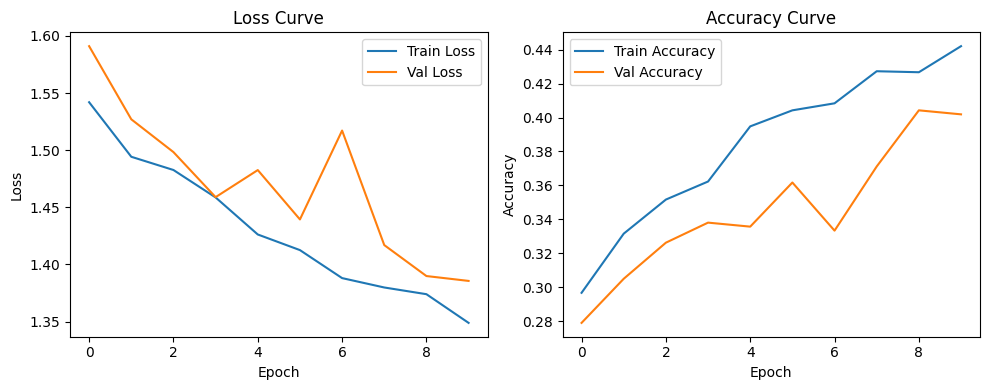

--------------------------------------------------


Fold 2


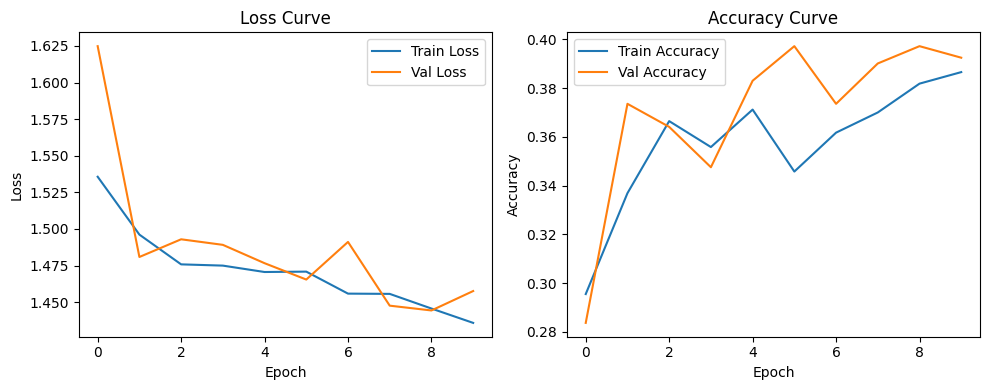

--------------------------------------------------


Fold 3


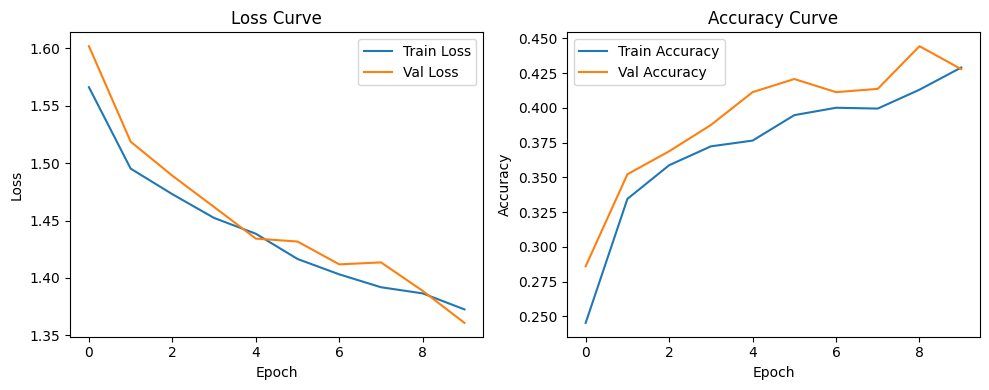

--------------------------------------------------


Fold 4


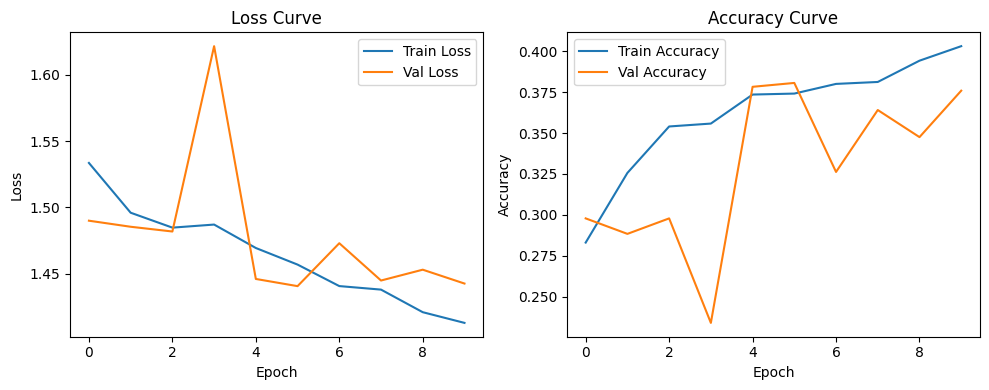

--------------------------------------------------


Fold 5


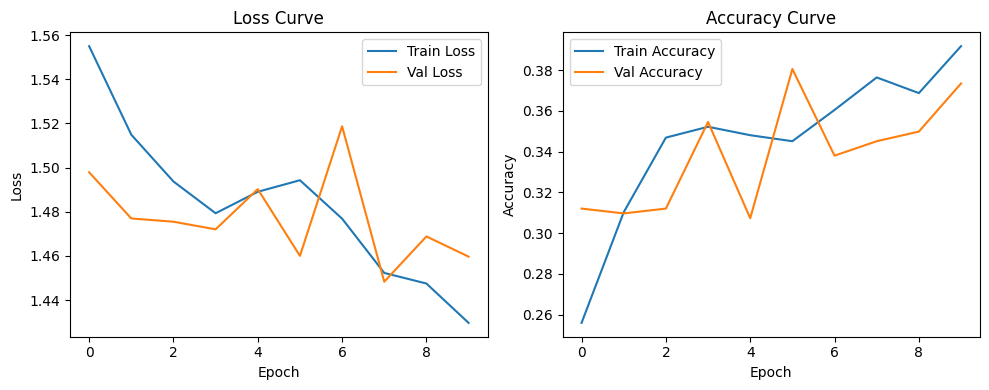

--------------------------------------------------




In [15]:
for fold, (train_losses, val_losses, train_accuracies, val_accuracies) in enumerate(zip(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)):
    print(f"Fold {fold+1}")
    plot_acc_loss_curves_train_vs_val(
        train_losses=train_losses, 
        val_losses=val_losses, 
        train_accuracies=train_accuracies, 
        val_accuracies=val_accuracies)
    print("-" * 50)
    print("\n")
    

In [16]:
criterion = torch.nn.CrossEntropyLoss()
test_metrics = evaluate(best_model, test_loader, criterion, prefix='test_')

test_Loss: 1.4053  test_Acc: 0.3771  test_Prec: 0.2614  test_Rec: 0.2911  test_F1: 0.2568  test_ROC-AUC: 0.6884


In [17]:
model_path = "./models/cross_validate_second_model_stratified.pkl"

In [18]:
save_model(best_model, model_path)

In [ ]:
best_model = load_model(model_path)

In [19]:
images, trues, preds = predict(best_model, test_loader)

In [21]:
label_to_index

{'Angry': 0, 'Happy': 1, 'Neutral': 2, 'Sad': 3, 'Surprised': 4}

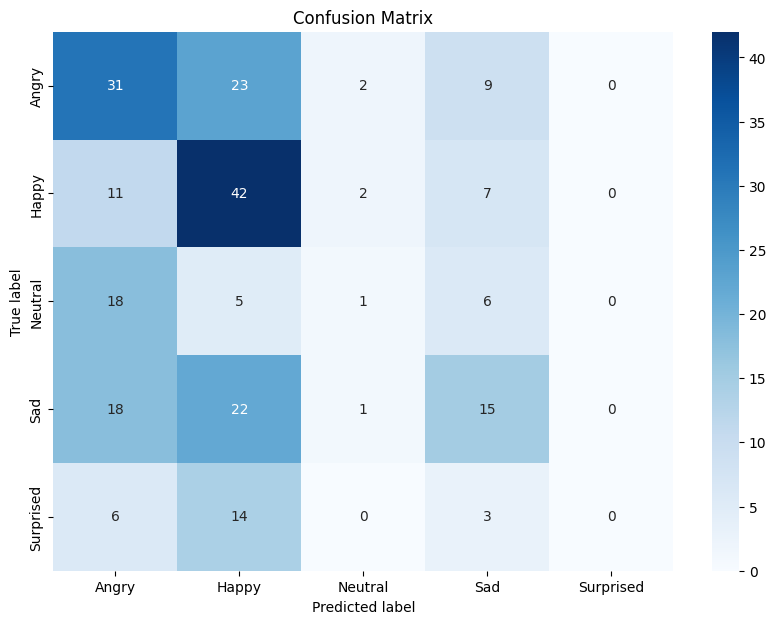

              precision    recall  f1-score   support

       Angry       0.37      0.48      0.42        65
       Happy       0.40      0.68      0.50        62
     Neutral       0.17      0.03      0.06        30
         Sad       0.38      0.27      0.31        56
   Surprised       0.00      0.00      0.00        23

    accuracy                           0.38       236
   macro avg       0.26      0.29      0.26       236
weighted avg       0.32      0.38      0.33       236



c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\001\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
plot_conf_mtrx(y_true=trues, y_pred=preds, classes=list(label_to_index.keys()))

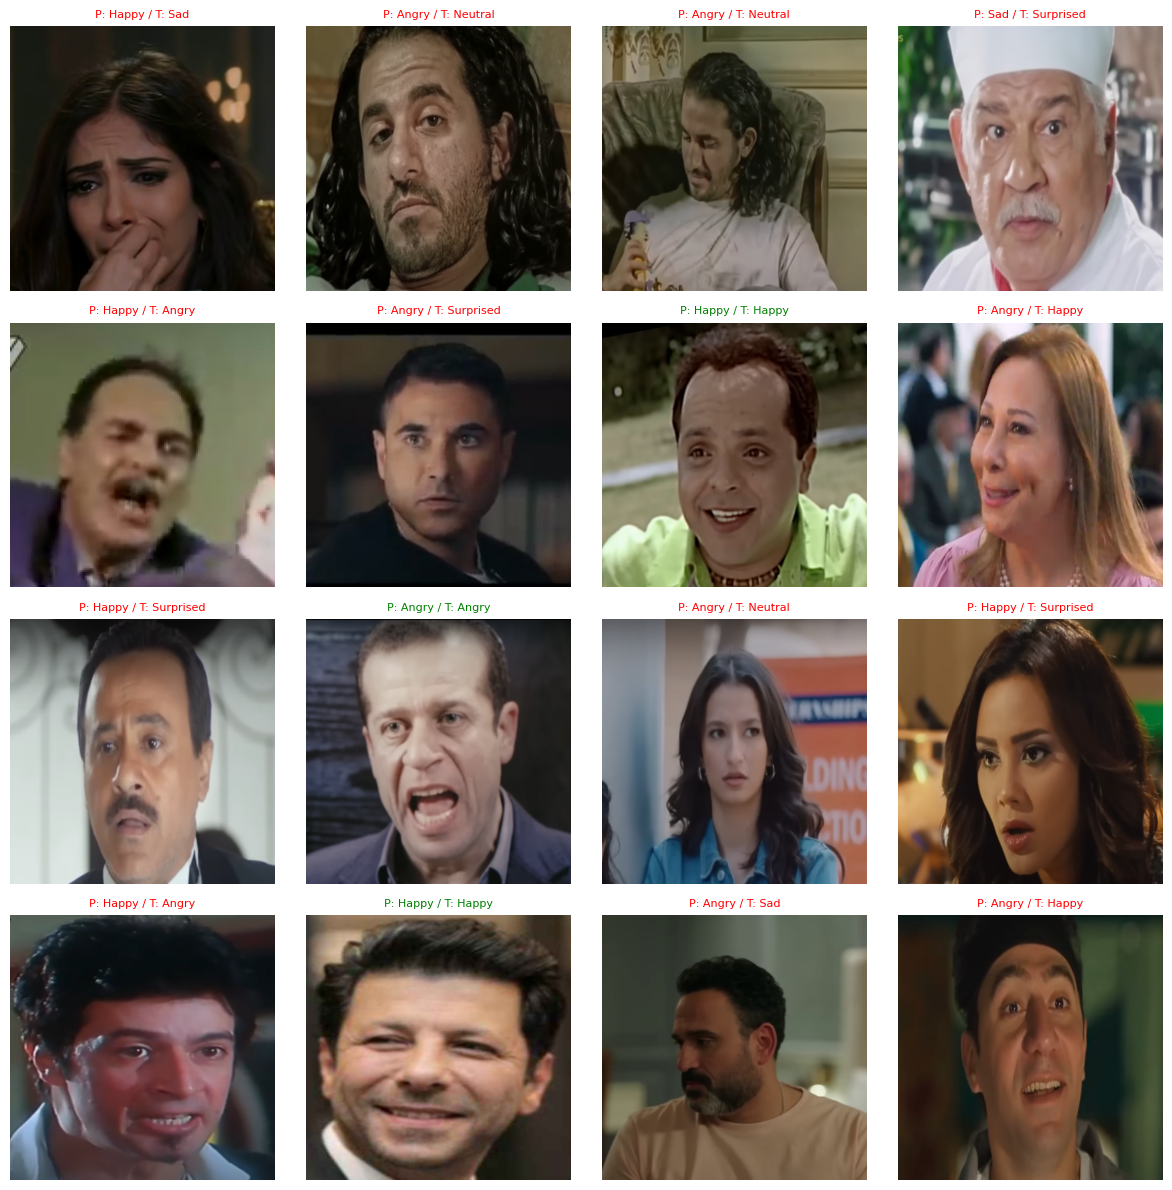

In [22]:
plot_predictions(images, trues, preds, index_to_label, num_images=16, nrow=4)